<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />

# Generando música<a id="top"></a>

<i>Last update: 2023-05-07</small></i></div>

***

## Introducción

En este _notebook_ vamos a crear un modelo que aprenderá a tocar «música». El entrecomillado es porque, para tocar música bien, se necesitan modelos y técnicas muy complejas que quedan un poco fuera del alcance de un tutorial como éste.

Sin embargo, en este ejercicio tocaremos los fundamentos de la generación basada en notas y acordes y, junto con los modelos que veremos más adelante en este tema más conceptos como redes bidireccionales e incrustaciones de la parte de procesamiento del lenguaje natural (NLP, del inglés _natural language processing_), podremos generar música con un poco más de sentido.

## Objetivos

Crearemos un modelo de predicción de notas basado en una secuencia de notas anteriores. Al final habremos aprendido a:

- Leer y escribir ficheros midi,
- Generar secuencias siguiendo una tipología de red recurrente _one-to-many_, y
- Guardar modelos entrenados en disco para entrenarlos en diferentes momentos.

## Bibliotecas y configuración

A continuación importaremos las librerías que se utilizarán a lo largo del _notebook_.

In [1]:
import glob
import os

import music21
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

2023-05-18 16:53:47.659758: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 16:53:47.853204: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-18 16:53:47.853222: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-18 16:53:48.806875: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

También vamos a configurar algunos parámetros para adaptar la presentación grafica.

In [2]:
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

Y crearemos los directorios necesarios en caso de que no se hayan creado previamente

In [3]:
os.makedirs('tmp', exist_ok=True)

***

## Carga y preparación de datos

Empezaremos cargando todas las notas de los archivos `.mid` ubicados en la ruta relativa `datasets/Music`. Estas notas se almacenarán en una lista llamada `notes`. Algunos detalles de implementación:

- Para parsear un fichero midi utilizaremos la función `parse(file)` del módulo `converter` de la librería `music21`,
- Las notas que queremos obtener están en el atributo `.flat.notes` del midi analizado. Sin embargo, tenemos que tener en cuenta que contiene dos tipos de datos:
  - Notas normales, que son del tipo `note.Note`. Si la nota es `note`, almacenaremos directamente en la lista de notas la representación en cadena de `note.pitch`.
  - Acordes, que son del tipo `chord.Chord`. Son una lista de notas, y lo que almacenaremos será la lista de sus notas (si el acorde es `chord`, la lista será `chord.normalOrder`) como una cadena de texto donde cada nota irá separada por un punto (`'.'`).

Esto no espor capricho; es una forma de representar las notas que facilitará la conversión posterior de las notas generadas en una nueva pista de audio.

In [4]:
notes = []  # Almacenará todas las notas y acordes de los ficheros

for file in glob.glob('datasets/music/doom/*.mid'):
    print(f'Parsing {file}')

    midi = music21.converter.parse(file)
    
    for note_or_chord in midi.flat.notes:
        if isinstance(note_or_chord, music21.note.Note):
            notes.append(str(note_or_chord.pitch))
        elif isinstance(note_or_chord, music21.chord.Chord):
            notes.append('.'.join(str(n) for n in note_or_chord.normalOrder))
notes[:10]

Parsing Datasets/Midi/Doom/DOOM1_e3m9.mid
Parsing Datasets/Midi/Doom/DOOM_2_MAP03.mid
Parsing Datasets/Midi/Doom/DOOM1_e3m5.mid
Parsing Datasets/Midi/Doom/DOOM1_intro.mid
Parsing Datasets/Midi/Doom/DOOM_2_MAP05.mid
Parsing Datasets/Midi/Doom/DOOM1_e2m6.mid
Parsing Datasets/Midi/Doom/DOOM1_e1m5.mid
Parsing Datasets/Midi/Doom/DOOM1_e1m8.mid
Parsing Datasets/Midi/Doom/DOOM1_e2m3.mid
Parsing Datasets/Midi/Doom/DOOM_2_READ_M.mid
Parsing Datasets/Midi/Doom/DOOM_2_MAP31.mid
Parsing Datasets/Midi/Doom/DOOM_2_MAP28.mid
Parsing Datasets/Midi/Doom/DOOM1_e1m4.mid
Parsing Datasets/Midi/Doom/DOOM1_e3m7.mid
Parsing Datasets/Midi/Doom/DOOM1_e2m5.mid
Parsing Datasets/Midi/Doom/DOOM1_e2m2.mid
Parsing Datasets/Midi/Doom/DOOM1_e3m2.mid
Parsing Datasets/Midi/Doom/DOOM_2_MAP18.mid
Parsing Datasets/Midi/Doom/DOOM_2_MAP04.mid
Parsing Datasets/Midi/Doom/DOOM1_e1m9.mid
Parsing Datasets/Midi/Doom/DOOM_2_MAP10.mid
Parsing Datasets/Midi/Doom/DOOM_2_MAP07.mid
Parsing Datasets/Midi/Doom/DOOM1_e1m3.mid
Parsing Datase

['E-4', 'E-3', 'E-2', 'B-2', 'C#4', 'C#3', 'C#2', 'G#2', 'C#4', 'C#3']

Nuestro siguiente paso será crear dos diccionarios: `note_to_int` y `int_to_note`. ¿Cuál será su significado? Pues que tenemos la lista de todas las notas de todas las pistas de sonido. Como las redes trabajan con números, no con símbolos, lo que haremos será asignar un valor único a cada nota diferente. Con estos dos diccionarios sabremos traducir de nota a número y de un número a su nota para poder traducir dentro y fuera de la red.

Por lo tanto, crearemos estos dos diccionarios con las diferentes notas en orden ascendente, desde 0 hasta el número de notas menos una.

In [15]:
note_to_int = {note: i for i, note in enumerate(sorted(set(notes)))}
int_to_note = {i: note for i, note in enumerate(sorted(set(notes)))}

Continuamos con la preparación de los conjuntos de datos. En `notas` tenemos la lista ordenada de notas. Se espera que las notas estén determinadas por la secuencia anterior. Por facilitar la implementación, no hemos creado un nuevo token para indicar que una canción ha terminado, por lo que habrá ciertas pausas que no se correspondan con un compás real. Si te apetece modificarlo, ¡adelante!

Lo que crearemos ahora será el conjunto de entrenamiento, las variables `x_train` y `y_train`. `y_train` estará formado por las secuencias de entrada, que tendrán una longitud de 50 (la variable SEQUENCE_LEN, ya creada), mientras que `y_train` tendrá la nota correspondiente a continuación de esa secuencia. Construiremos este conjunto a partir de la lista `notas`.

In [16]:
SEQUENCE_LEN = 20

x_train = []
y_train = []

for i in range(SEQUENCE_LEN, len(notes)):
    input_notes = notes[i - SEQUENCE_LEN: i]
    output_note = notes[i]
    x_train.append([note_to_int[note] for note in input_notes])
    y_train.append(note_to_int[output_note])

for i in range(10):
    print(f'{x_train[i]} -> {y_train[i]}')

[154, 153, 152, 120, 133, 132, 131, 180, 133, 132, 131, 180, 127, 126, 125, 167, 133, 132, 131, 180] -> 133
[153, 152, 120, 133, 132, 131, 180, 133, 132, 131, 180, 127, 126, 125, 167, 133, 132, 131, 180, 133] -> 132
[152, 120, 133, 132, 131, 180, 133, 132, 131, 180, 127, 126, 125, 167, 133, 132, 131, 180, 133, 132] -> 131
[120, 133, 132, 131, 180, 133, 132, 131, 180, 127, 126, 125, 167, 133, 132, 131, 180, 133, 132, 131] -> 180
[133, 132, 131, 180, 133, 132, 131, 180, 127, 126, 125, 167, 133, 132, 131, 180, 133, 132, 131, 180] -> 154
[132, 131, 180, 133, 132, 131, 180, 127, 126, 125, 167, 133, 132, 131, 180, 133, 132, 131, 180, 154] -> 153
[131, 180, 133, 132, 131, 180, 127, 126, 125, 167, 133, 132, 131, 180, 133, 132, 131, 180, 154, 153] -> 152
[180, 133, 132, 131, 180, 127, 126, 125, 167, 133, 132, 131, 180, 133, 132, 131, 180, 154, 153, 152] -> 120
[133, 132, 131, 180, 127, 126, 125, 167, 133, 132, 131, 180, 133, 132, 131, 180, 154, 153, 152, 120] -> 133
[132, 131, 180, 127, 126, 12

Como vamos a alimentar una red recurrente, las dimensiones de entrada deben ser $M \times T \times C$, siendo:

- $M$: El número de ejemplos, es decir, el número total de secuencias.
- $T$: El tamaño de la secuencia, que hemos definido en la constante anterior.
- $C$: El número de parámetros que tiene cada elemento de la secuencia, que en nuestro caso es $1$ (cada nota es un único entero).

El problema es que las dimensiones de nuestro conjunto de entrenamiento no son esas, por lo que tendremos que remodelar el conjunto de entrenamiento.

In [17]:
x_train = np.reshape(x_train, (len(x_train), SEQUENCE_LEN, 1)) # (M, T, C)

print(f'x_train shape: {x_train.shape}')

x_train shape: (88215, 20, 1)


Ahora normalizaremos los datos de entrada para que caigan dentro del intervalo $[0, 1]$.

In [18]:
x_train = x_train / len(note_to_int)
y_train = np.array(y_train)

print(f'An x_train value: {x_train[0][0]}')

An x_train value: [0.79792746]


Y con los conjuntos creados y listos para entrenar, pasamos a trabajar con el modelo.

## Implementando y entrenando el modelo

Vamos a añadir un nuevo elemento que no habíamos visto hasta ahora pero que es muy útil cuando trabajamos con modelos grandes: un callback para almacenar puntos de control con los estados del modelo. Los argumentos del inicializador de la clase son bastante descriptivos.

In [19]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'tmp/music-generator-{loss:.4f}.h5',
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

Ahora crearemos un modelo para que aprenda a predecir la siguiente nota dada una secuencia de notas. El modelo se compilará con la pérdida correspondiente a un problema de clasificación y se utilizará el algoritmo Adam como optimizador.

In [22]:
LOAD_PREVIOUS = True

checkpoints = sorted(glob.glob('tmp/music-generator-*.h5'))
if LOAD_PREVIOUS and checkpoints:
    print(f'Loading previous model: {checkpoints[0]}')
    model = tf.keras.models.load_model(checkpoints[0])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, activation='relu', return_sequences=True), input_shape=x_train.shape[1:],),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, activation='relu', return_sequences=True)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, activation='relu')),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(len(set(y_train)), activation='softmax')
    ])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['sparse_categorical_accuracy'],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 20, 1024)         1582080   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 20, 1024)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 1024)         4724736   
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 20, 1024)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 1024)             4724736   
 nal)                                                            
                                                        

Ahora entrenaremos el modelo con nuestro conjunto de datos durante 25 épocas; no son muchas, pero la carga computacional derivada del entrenamiento de este tipo de modelos es bastante pesada.

In [ ]:
history = model.fit(x_train, y_train, epochs=25, callbacks=[checkpoint], batch_size=512)

Epoch 1/25
 73/173 [===========>..................] - ETA: 10:54 - loss: 4.3599 - sparse_categorical_accuracy: 0.0430

Antes de ver la evolución del error, podríamos modificar la creación del modelo para que cargue el mejor punto de control si existe y si queremos (mediante una variable, por ejemplo `LOAD_PREVIOUS`).

Ahora, veamos cómo han evolucionado error y exactitud.

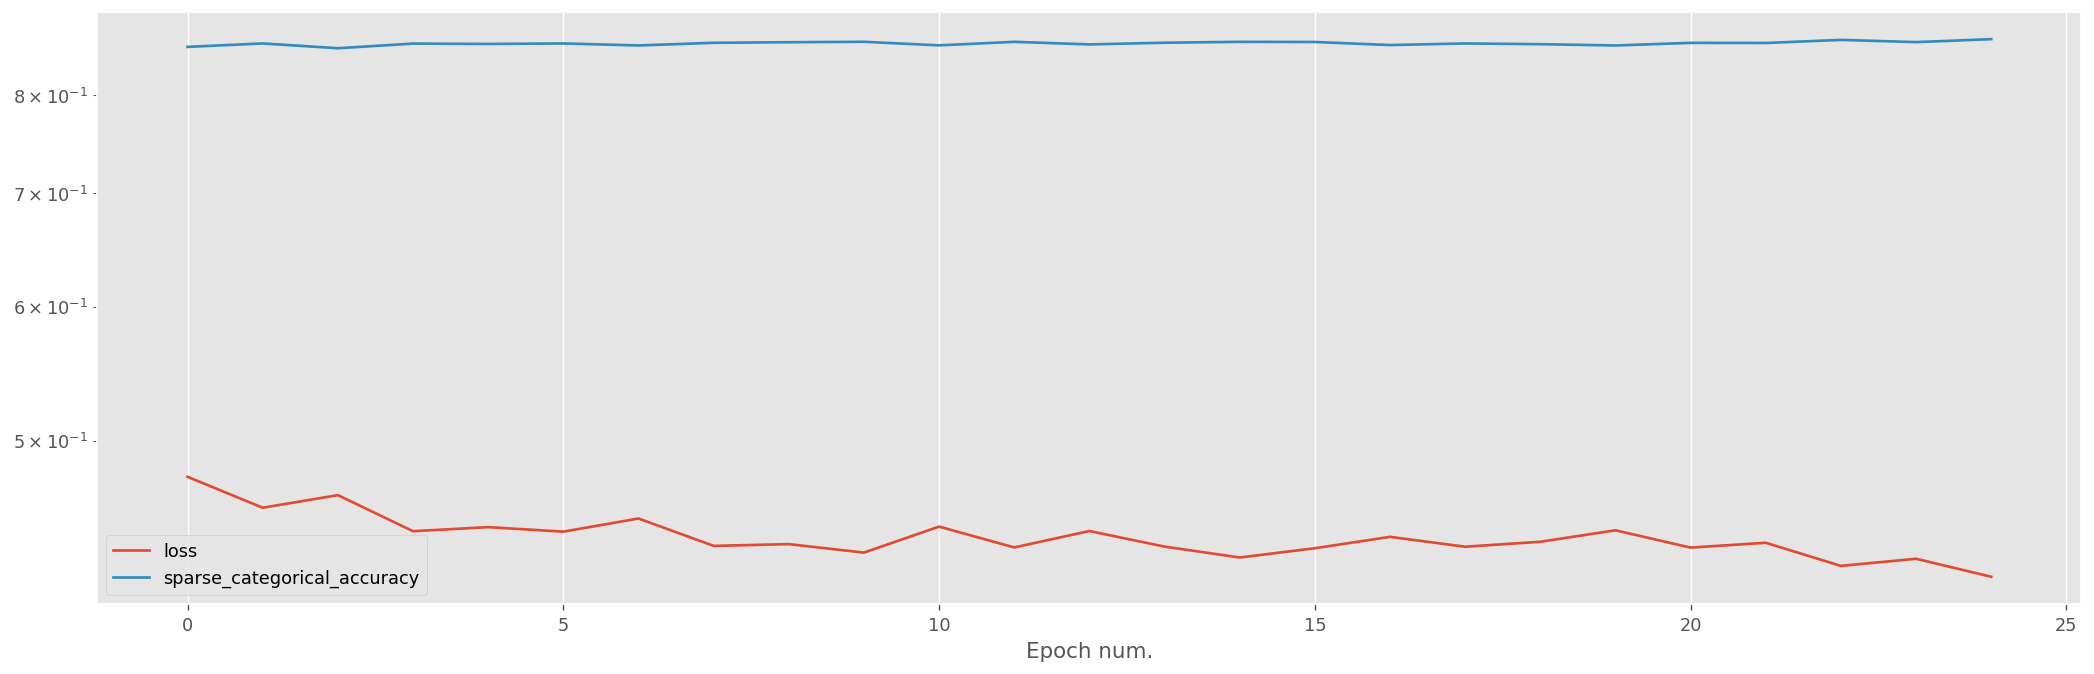

In [12]:
pd.DataFrame(history.history).plot()
plt.yscale('log')
plt.xlabel('Epoch num.')
plt.show()

## A generar música

Ya tenemos un modelo entrenado para generar música. Ahora procederemos a generar una canción. Para hacerlo sencillo, generaremos una canción de N notas (digamos 100, y veremos cómo se comporta. Para ello haremos lo siguiente

1. Crear una secuencia aleatoria de inicio del tamaño de secuencia esperado, lo que constituirá nuestra primera entrada,
2. Pasar esa secuencia al modelo y recoger la siguiente nota que predice,
3. Eliminar la primera nota de la secuencia y añadir la nueva nota al final, lo que constituirá la siguiente secuencia, y
4. Continuar así hasta terminar de generar notas.

El resultado será una lista con la secuencia y todas las notas generadas. La lista con las notas generadas se llamará `new_song`.

In [13]:
start = np.random.randint(len(x_train) - 1)
pattern = x_train[start]

new_song = []
for _ in range(100):
    X = np.reshape(pattern, (1, SEQUENCE_LEN, 1))

    next_note_softmax = model.predict(X, verbose=0)
    next_note = np.argmax(next_note_softmax)

    new_song.append(int_to_note[next_note])

    pattern[:-1] = pattern[1:]
    pattern[-1] = next_note / len(note_to_int)
    
print(f'New song: {new_song}')

New song: ['B1', 'B4', 'F#4', 'D4', 'B2', 'F#3', 'B1', 'B2', 'F#3', 'F#4', 'D4', 'B3', 'B2', 'F#3', 'B1', 'D4', 'B3', 'F#3', 'B2', 'F#3', 'F#2', 'B2', 'F#3', 'C#4', 'F#3', 'G3', 'B3', 'E3', 'F#2', 'B2', 'F#3', 'B2', 'F#3', 'B2', 'F#3', 'B2', 'E3', 'E-1', 'B2', 'F#3', 'G#3', 'B3', 'E3', 'B2', 'G3', 'B2', 'B2', 'G3', 'B2', 'G3', 'G3', 'B3', 'E3', 'B2', 'G3', 'G4', 'B3', 'B2', 'B2', 'G3', 'B2', 'G3', 'E4', 'B3', 'G3', 'B2', 'G3', 'B2', 'G3', 'F#2', 'B2', 'G3', 'B2', 'G3', 'E3', 'B2', 'G3', 'B2', 'G3', 'B2', 'G3', 'B2', 'G3', 'E5', 'B4', 'G3', 'F#4', 'E4', 'B3', 'B2', 'G3', 'B2', 'G3', 'F#4', 'B3', 'A3', 'B2', 'G3', 'B2', 'G3']


El siguiente fragmento de código transforma la lista de notas en un midi, separando cada nota por medio segundo.

In [14]:
# Now let's create the midi given the song
offset = 0
output_notes = []

# Create notes and chords according with the specified song
for pattern in new_song:
    if ('.' in pattern) or pattern.isdigit():
        # Pattern is a chord, so let's split into notes and create it
        notes = []
        for current_note in pattern.split('.'):
            new_note = music21.note.Note(int(current_note))
            new_note.storedInstrument = music21.instrument.Violin()
            notes.append(new_note)
        new_chord = music21.chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    else:
        # Pattern is a note, so let's create it and that's all
        new_note = music21.note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = music21.instrument.Violin()
        output_notes.append(new_note)

    # Increase note ofet so no notes stack
    offset += 0.5

midi_stream = music21.stream.Stream(output_notes)
midi_stream.write('midi', fp='tmp/test_output.mid')

'tmp/test_output.mid'

Como puedes ver, el modelo ha generado una canción. Sí, no respetamos los tiempos, hay secuencias que no tienen sentido (los cortes entre canciones), etc., pero nos ha servido como experimento para ver el desarrollo de un proyecto de principio a fin.

## Conclusiones

Hemos implementado un modelo recurrente que aprende de muchos datos para resolver un problema _de_uno_a_muchos_: generar música a partir de una semilla inicial.

Os animamos a modificar la arquitectura para ver si encontráis una que genere canciones que tengan algún sentido, y a probar a añadir entradas aleatorias durante el entrenamiento para que durante la inferencia se puedan añadir dichas entradas para alterar la generación de melodías.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Back to top](#top)

</div>